In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
df = pd.read_csv('./data/train.csv')

In [3]:
print('No. of data points:',df.shape[0])

No. of data points: 404290


In [4]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


- question 1 has 1 null value, question 2 has 2 null values

### Distribution of Data points among output classes

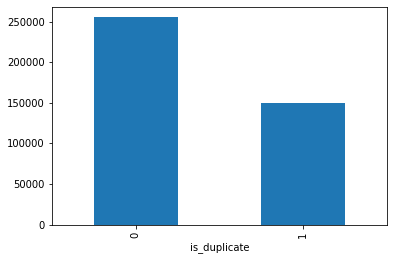

In [6]:
df.groupby('is_duplicate')['id'].count().plot.bar()

#### OR

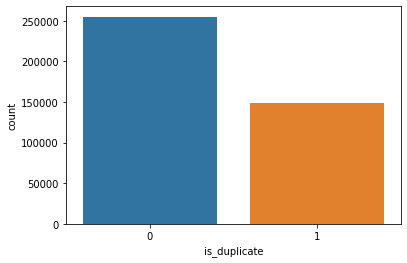

In [7]:
sns.countplot('is_duplicate',data=df)
plt.show()

In [8]:
print('% of non-duplicate questions:' ,round(df.groupby('is_duplicate')['id'].count()[0]/df.shape[0]*100,3),'%')
print('% of duplicate questions:' ,round(df.groupby('is_duplicate')['id'].count()[1]/df.shape[0]*100,3),'%')

% of non-duplicate questions: 63.08 %
% of duplicate questions: 36.92 %


### Number of unique questions
- 1 2
- 2 3
- 2 4 
- 3 1
- 4 1
- we  can see the number of unique questions are only 4

In [9]:
len(df['qid1'].tolist())

404290

In [10]:
len(df['qid1'].tolist() + df['qid2'].tolist())

808580

In [11]:
len(df['qid1'] + df['qid2'])

404290

- we are first converting it into list...adding both the column values..then finding out the number of unique questions we have

In [12]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = qids.nunique()
#unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print('Total Number of unique questions are: ',unique_qs)
print('Questions that repeat more than once are: ',qs_morethan_onetime,'({} %)'.format(np.round(qs_morethan_onetime/unique_qs*100,2)))
print('Maximum number of times a question is repeated: ',max(qids.value_counts()))

q_vals = qids.value_counts().values

Total Number of unique questions are:  537933
Questions that repeat more than once are:  111780 (20.78 %)
Maximum number of times a question is repeated:  157


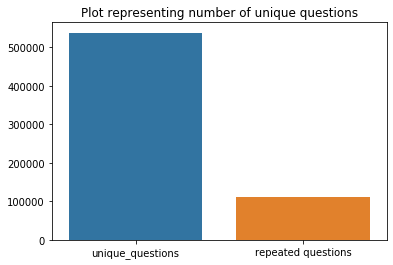

In [13]:
x = ['unique_questions','repeated questions']
y = [unique_qs, qs_morethan_onetime]

plt.title('Plot representing number of unique questions')
sns.barplot(x,y)
plt.show()

In [14]:
np.sum(qids.value_counts() == 1) 

426153

In [15]:
len(np.unique(qids))

537933

- i guess there is a mistake, in video it has said that unique questions are 80%...426153 should be 80%

### Checking for any duplicate number of questions
- checking if any pair of question is getting repeated
- 1 2 
- 1 3
- 1 2

In [16]:
pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
print('Number of duplicate questions are',pair_duplicates.shape[0] - df.shape[0])
# pairs of q1 and q2 are exactly equal to the shape 

Number of duplicate questions are 0


### Number of occurences of each question

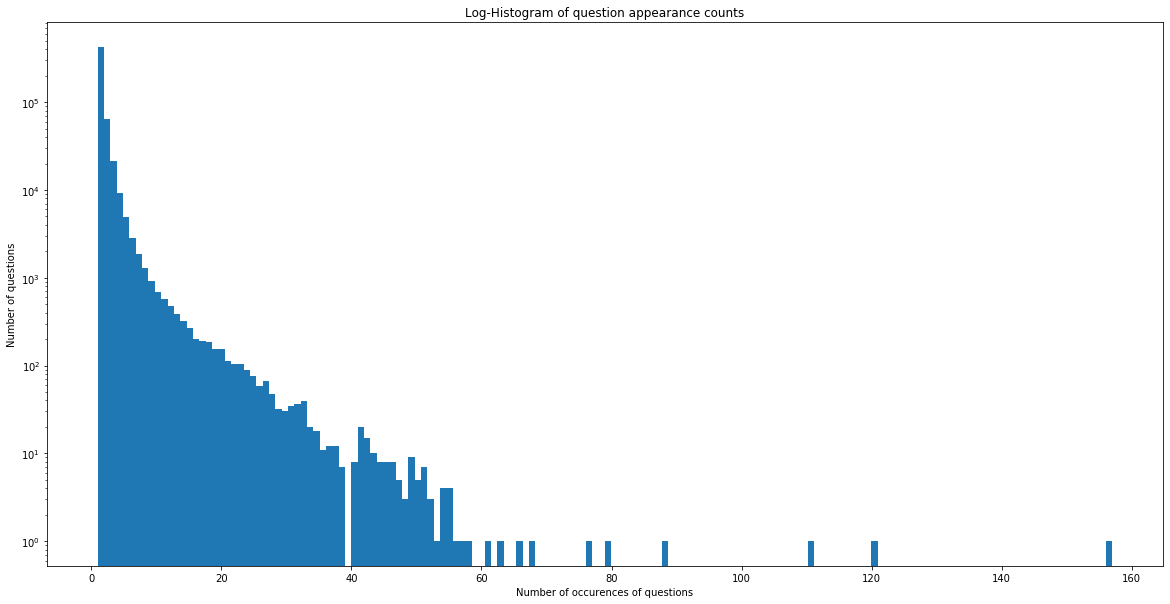

In [17]:
plt.figure(figsize=(20,10))
plt.hist(qids.value_counts(),bins=160)
plt.yscale('log')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of questions')
plt.ylabel('Number of questions')
plt.show()


- 157 times occurence of only 1 question (as height 1 hai)
- questions that occur only once are maximum 
- 1 question that appears 120 times
- but most of the data lies in the starting..which means most of the questions occure very few times

In [10]:
nan_rows = df[df.isnull().any(1)]
nan_rows
#print(nan_rows)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len


- there are 2 rows with null values in question 2
- there is 1 row with null value in question 1

In [9]:
# Filling the null values with ' '
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print(nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate, freq_qid1, freq_qid2, q1len, q2len]
Index: []


## Basic Feature Extraction (before cleaning)

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [33]:
print(df.groupby('qid1')['qid1'].count())
print('='*60)
print(df.groupby('qid1')['qid1'].transform('count'))

print('='*60)
print('Transform has make this column equal to the length of our dataset(so that we can merge)')

qid1
1         1
3         4
4         1
5         1
7         1
         ..
537924    1
537926    1
537928    1
537930    1
537932    1
Name: qid1, Length: 290654, dtype: int64
0          1
1          4
2          1
3          1
4          3
          ..
404285     2
404286    12
404287     1
404288     1
404289     1
Name: qid1, Length: 404290, dtype: int64
Transform has make this column equal to the length of our dataset(so that we can merge)


In [32]:
df[df['qid1']==3]

,id,qid1,qid2,question1,question2,is_duplicate
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
184732,184732,3,282170,What is the story of Kohinoor (Koh-i-Noor) Dia...,Is it possible to melt down diamonds?,0
263614,263614,3,380197,What is the story of Kohinoor (Koh-i-Noor) Dia...,What are some interesting facts about Kohinoor...,0
359232,359232,3,488853,What is the story of Kohinoor (Koh-i-Noor) Dia...,Could India keep the Koh-I-Noor safe?,0


In [42]:
#word-common
#set me daal rhe because we need unique words...also remove question mark
print(set(map(lambda word: word.lower().strip(),df['question1'][90].replace('?','').split())))

{'11th', 'book', 'the', 'what', 'class', 'reference', 'for', 'is', 'best', 'physics'}


- like freq_qid1 of qid==3 is 4..so transform will make value 4 in each of the 4 columns

In [30]:
if os.path.isfile('mine_df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv('mine_df_fe_without_preprocessing_train.csv')

else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') #doing this so that we can see frequency of qid1(how many times ques 1 is repeating) then transforming(will make the values to be able to fit with other columns)
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len()
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))
    
    # these are unique common words
    def normalized_word_common(row): 
        # lower because if some word is capital we will make it lower
        w1 = set(map(lambda word: word.lower().strip(),row['question1'].split()))
        w2 = set(map(lambda word: word.lower().strip(),row['question2'].split()))
        return 1.0*len(w1 & w2)
    df['word_common'] = df.apply(normalized_word_common,axis=1)
    
    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)
    

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("mine_df_fe_without_preprocessing_train.csv", index=False)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


### Analysis of some of the extracted features

Questions with only one single word

In [46]:
print('Minimum length of the question in question1:',min(df['q1_n_words']))
print('Minimum length of the question in question2:',min(df['q2_n_words']))

print('Number of questions with minimum length in question1:',sum(df['q1_n_words']==1))
print('Number of questions with minimum length in question2:',sum(df['q2_n_words']==1))

Minimum length of the question in question1: 1
Minimum length of the question in question2: 1
Number of questions with minimum length in question1: 67
Number of questions with minimum length in question2: 24


##### Feature word-share

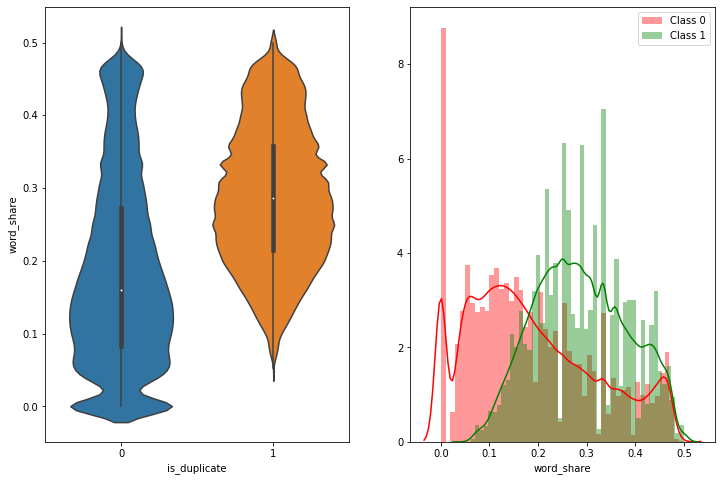

In [68]:
plt.figure(figsize=(12,8))

plt.subplot(121)
sns.violinplot(x='is_duplicate',y='word_share',data=df)

plt.subplot(122)
sns.distplot(df[df['is_duplicate']==0]['word_share'],color='red',label='Class 0')
sns.distplot(df[df['is_duplicate']==1]['word_share'],color='green',label='Class 1')

plt.legend()
plt.show()

- We can see after a particular value of word_share we can distiniguish the 2 distributions
- words which have high value of word-share are duplicate(similar questions)
- also box-plot in the violin plot tend to have some overlap in them

##### Feature word-common

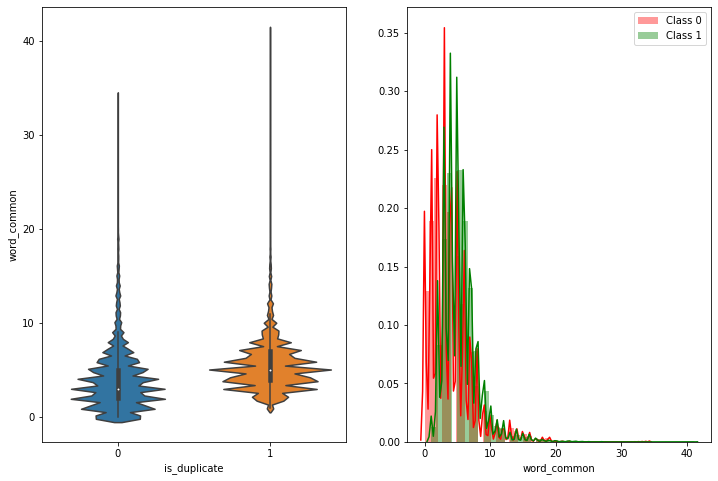

In [72]:
plt.figure(figsize=(12,8))

plt.subplot(121)
sns.violinplot(x='is_duplicate',y='word_common',data=df)

plt.subplot(122)
sns.distplot(df[df['is_duplicate']==0]['word_common'],color='red',label='Class 0')
sns.distplot(df[df['is_duplicate']==1]['word_common'],color='green',label='Class 1')

plt.legend()
plt.show()

- The distributions of the word-common feature in similar and non-similar questions are highly overlapping
- Therefore not so useful